In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pyspeckit

from matplotlib.colors import ListedColormap

## Read data files

In [4]:
nh3_11, hd_amm = fits.getdata('datacubes/nh3_11_whole_cube_8as_3px.fits', header=True)
npeaks, hd2d = fits.getdata('bayesian_fit_files/npeaks_cut5.fits', header=True)
snr = fits.getdata('bayesian_fit_files/snr11.fits')

#### Area masks (from Schmiedeke et al., 2021)

In [3]:
from os import listdir

fls = listdir('data_files_prev_works/masks_anika')
fls = [i for i in fls if 'rgrd.fits' in i]

msk_regs = {ms[:-10] : fits.getdata('data_files_prev_works/masks_anika/'+ms) for ms in fls}

#### coherent core boundary from Pineda et al., 2010

In [8]:
coh_core_bndry_fle = 'data_files_prev_works/coherent_core_bound_SD.fits'

### Aplpy plots

In [4]:
from aplpy import FITSFigure
from astropy.io.fits import PrimaryHDU
import astropy.units as u

import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [5]:
def aplpy_plot(fig= None, fgsz=(7,7), data=None, hd=None, cmap='inferno', vmin=9.7, vmax=10.7, vmid=None, 
               colourscale_stretch='linear', colourbar=True, colourbar_text=r'$\rm{v_{LSR}}\ (km\,s^{-1})$', 
               colourbar_loc='right', beam_colour='green', bm_clr='k', x_bm_lbl=0.07, y_bm_lbl=0.07, 
               scalebar_corner='top right', background_grey=False, bckgr_gr_clr='0.8', zoom=False, 
               sbplt=[0, 0, 1, 1], contours=False, contour_clr='k') :
    """ 
    return aplpy FITSfigure for given data
    
    fig                 : matplotlib figure instance. If not given, a new figure is created
    fgsz                : size of the figure, if created new. Default is (7,7)
    
    data                : 2d array containing the data to be plotted, required
    hd                  : associated header, required
    
    cmap                : colourmap to be used. Default is 'inferno'
    vmin, vmax          : min,max of the colourscale. Default is (9.7, 10.7)
    vmid                : vmid for the colour scale. Required if the stretch is 'log'. Default is 'None'
    colourscale_stretch : stretch for the colour scale. Default is 'linear'
    
    colourbar           : bool. Whether the colourbar should be shown. Default is 'True'
    colourbar_text      : text accompanying the colourbar. Default is for v_lsr
    colourbar_loc       : location of the colourbar on the map. Default is 'right'
    
    beam_colour         : colour of the beam to be shown. Default is 'green'
    bm_clr              : colour of the text accompanying beam (the region name), default is k
    x_bm_lbl, y_bm_lbl  : position of the accompanying text (region name). Default is (0.07, 0.07)
    
    scalebar_corner     : position of the scale bar. Default is 'top right'
    
    background_grey     : whether to set background NaN to a different colour instead of the default white. 
                         Default is 'False'
    bckgr_gr_clr        : colour of the background NaN. Default is '0.8'
    
    
    zoom                : ff set to 'True', the figure shows a zoomed-in view of the B5 core. Default is 'False'
    
    sbplt               : which subplot to use. Only used if an existing figure is passed. Default is [0, 0, 1, 1] 
    
    contours            : whether to show the contours of the different regions (filaments 1 & 2, 
                          condensations 1, 2 & 3). Default is False
    contour_clr         : colour of the region contours, default is black
    """

    # generate a new matplotlib figure if one is not provided
    if not fig:
        fig = plt.figure(figsize=fgsz)

    # create an aplpy.FITSfigure with given data and header
    fig = FITSFigure( data=PrimaryHDU(data=data, header=hd), figure=fig, subplot=sbplt)
    
    # set background colour to the one given
    if background_grey:
        cmap = plt.get_cmap(cmap)
        cmap.set_bad(bckgr_gr_clr)

    # show the colour map 
    fig.show_colorscale( cmap=cmap, vmin=vmin, vmax=vmax,stretch=colourscale_stretch, vmid=vmid)
    
    # set coloud bar instance
    if colourbar:
        fig.add_colorbar()
        fig.colorbar.show(location=colourbar_loc, axis_label_text=colourbar_text)
    
    # add beam
    fig.add_beam(color=beam_colour)
    
    # add scalebar at a distance of 302 pc (for B5)
    distance = 302 *u.pc
    scale=(0.1*u.pc/distance*u.rad).to(u.deg)
    fig.add_scalebar(scale, label='0.1 pc', corner=scalebar_corner)
#     fig.set_nan_color('0.7')
    fig.ticks.set_color('black')
    
    # write name of the region : B5
    fig.add_label( x_bm_lbl, y_bm_lbl, 'B5', relative=True, color= bm_clr, size=15)
    
    # zoom around the core
    if zoom:
        fig.recenter(56.914, 32.879, width=0.13, height=0.138)

    # show contours of filament 1, filament 2, condensation 1, condensation 2 and condensation 3
    if contours :
        fig.show_contour(msk_regs['fil1'], colors=[contour_clr], levels=[0])
        fig.show_contour(msk_regs['fil2'], colors=[contour_clr], levels=[0])

        fig.show_contour(msk_regs['cnd1'], colors=[contour_clr], levels=[0], linestyles='dashed')
        fig.show_contour(msk_regs['cnd2'], colors=[contour_clr], levels=[0], linestyles='dashed')
        fig.show_contour(msk_regs['cnd3'], colors=[contour_clr], levels=[0], linestyles='dashed')
    
    return fig

### calculate simple moment 0

In [5]:
sum_11 = np.nansum(nh3_11, axis=0)                          # sum along the spectral axis 

dv_ms = (hd_amm['CDELT3']/hd_amm['CRVAL3']) * 299792458     # width of one channel in m/s, calculated using rest
                                                            # frequency and frequency resolution
    
dv_kms = dv_ms/1000                                         # channel width in km/s

integ_inten = sum_11 * dv_kms                               # integrated intensity 

integ_inten[integ_inten == 0] = np.nan                      # np.nunsum returns sum of NaNs as 0. This is to set 
                                                            # the integrated intensity in pixels without emission
                                                            # as NaNs instead of 0

#### write out/read in the moment 0 data

In [7]:
# fits.writeto('datacubes/nh3_11_mom0.fits', integ_inten, hd2d, overwrite=True)
integ_inten = fits.getdata('datacubes/nh3_11_mom0.fits')

#### plot the integrated intensity in $\rm NH_3$ (1,1)

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


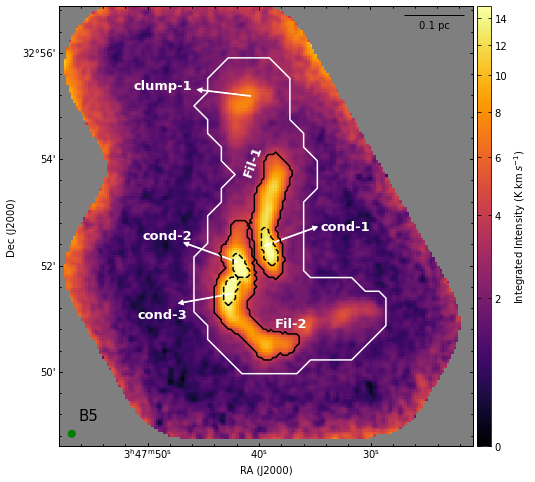

In [16]:
fig = aplpy_plot(data=integ_inten, hd=hd2d, cmap='inferno', zoom=True, fgsz=(6,10), vmin=0, vmax=15, vmid=-2, 
                 contours=True, contour_clr='k', background_grey=True, bckgr_gr_clr='0.5', 
                 colourbar_text=r'Integrated Intensity (K km$\,s^{-1}$)', colourscale_stretch='log')

# show the coherent core boundary
fig.show_contour(coh_core_bndry_fle, levels=[0.5], colors='w')

### show markers pointing to the different regions inside the core ###

# Clump-1
fig.show_arrows(56.92, 32.92, 0.02, 0.002, width=0.3, head_width=2, head_length=2, color='w')
fig.add_label( 0.18, 0.82, 'clump-1', relative=True, color='w',size=13, weight=1000, horizontalalignment='left')

# Filament 1 and 2
fig.add_label( 0.44, 0.65, 'Fil-1', relative=True, color='w',size=13, weight=1000, rotation=70, 
              horizontalalignment='left')
fig.add_label( 0.52, 0.28, 'Fil-2', relative=True, color='w',size=13, weight=1000, horizontalalignment='left')

# Condensations 1, 2, and 3
fig.show_arrows(56.915, 32.873, -0.02, 0.006, width=0.3, head_width=2, head_length=2, color='w')
fig.add_label( 0.63, 0.5, 'cond-1', relative=True, color='w',size=13, weight=1000, horizontalalignment='left')
fig.show_arrows(56.925, 32.868, 0.02, 0.006, width=0.3, head_width=2, head_length=2, color='w')
fig.add_label( 0.26, 0.479, 'cond-2', relative=True, color='w',size=13, weight=1000)
fig.show_arrows(56.927, 32.858, 0.02, -0.003, width=0.3, head_width=2, head_length=2, color='w')
fig.add_label( 0.25, 0.3, 'cond-3', relative=True, color='w',size=13, weight=1000)

fig.savefig('plots/mom0_sel-chan_w-labels.pdf', dpi=1000)

### Show example spectra with 2, 3 component fits

In [13]:
from astropy.wcs import WCS
wcs = WCS(hd2d)

from matplotlib.patches import Circle

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


In [14]:
# x,y co-ordinates of the positions chosen for the example spectra
xlist = np.array([115, 125, 94])
ylist = np.array([73, 59, 94])

# lengths of the arrows in x- and y-axes
dxlist = np.array([30, 15, -40])
dylist = np.array([10, -40, 20])

# number labels of the positions (with 1-, 2-, and 3-components detected, respectively)
labels = np.array([1, 2, 3])

# calculate positions of markers and lengths of arrows in world co-ordinates
ra_list, dec_list = wcs.all_pix2world(xlist, ylist, 0)                                 # position of pixel
ra_list_text, dec_list_text = wcs.all_pix2world(xlist + dxlist, ylist + dylist, 0)     # position of marker
dra_list = ra_list - ra_list_text                                                      # length of arrow in RA
ddec_list = dec_list - dec_list_text                                                   # length of arrow in Dec

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


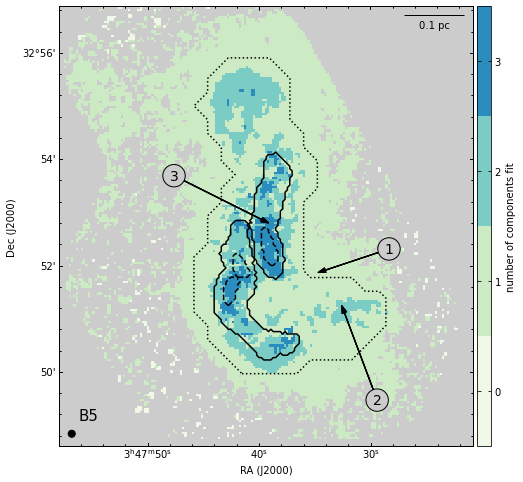

In [17]:
cmaplst = ['#f0f9e8', '#ccebc5', '#7bccc4', '#2b8cbe']         # colours representing number of components fit
lcmap = ListedColormap(cmaplst)                                # set colourmap with these colours
lcmap.set_bad('#f0f0f0')                                       # set NaN colour

# select positions above SNR=4
npeaks_snr5 = npeaks.copy()                                    # duplicate of the npeaks data array
npeaks_snr5[npeaks_snr5 == 0] = 10                             # set aside the 'true' 0s (pixels with no fits)
npeaks_snr5 = npeaks_snr5*(snr>4)                              # filter pixels with SNR>4, set all others to 0
npeaks_snr5[npeaks_snr5 == 0] = np.nan                         # set the SNR<=4 pixels as NaN
npeaks_snr5[npeaks_snr5 == 10] = 0                             # restore the 'true' 0 component pixels


# show number of components fit across the region
fig = aplpy_plot(data=npeaks_snr5, hd=hd2d, cmap=lcmap, zoom=True, fgsz=(6,10), vmin=-0.5, vmax=3.5, 
                 colourbar_text='number of components fit', background_grey=True, beam_colour='k', contours=True)

# a pixel can only have 0, 1, 2, or 3 components
fig.colorbar.set_ticks([0, 1, 2, 3])

# show the coherent core boundary
fig.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')

# show and label the positions for the spectra to be shown

for i in range(len(labels)):
    # labels
    fig.add_label( ra_list_text[i], dec_list_text[i], labels[i], color='k', size=14, weight=500, 
                  bbox=dict(boxstyle="circle", fc="0.8", alpha=1))
    # arrows pointing to the pixels
    fig.show_arrows(ra_list_text, dec_list_text, dra_list, ddec_list, head_width=2, width=0.1, color='k')
    
fig.savefig('plots/npeaks_w-contours_w-ex-spec-loc.pdf', dpi=1000)

## plot example spectra with fits

#### load files

In [6]:
# NH3 (1,1) cube
cb11 = pyspeckit.Cube('datacubes/nh3_11_whole_cube_8as_3px.fits')

# fitcubes from 1-, 2-, and 3-component fits
ftcb_1cmp_tk6 = fits.getdata('bayesian_fit_files/B5-mle-x1.fits')
ftcb_2cmp_tk6 = fits.getdata('bayesian_fit_files/B5-mle-x2.fits')
ftcb_3cmp_tk6 = fits.getdata('bayesian_fit_files/B5-mle-x3.fits')

#### get xarr

In [8]:
import astropy.units as u

In [9]:
cb11.unit="K"
cb11.xarr.refX = pyspeckit.spectrum.models.ammonia.freq_dict['oneone']
cb11.xarr.refX_unit='Hz'
cb11.xarr.velocity_convention='radio'
cb11.xarr.convert_to_unit(u.km/u.s)
xarr11 = cb11.get_spectrum(37,36).xarr

####  model function for different number of components 

In [10]:
modelf = pyspeckit.spectrum.models.ammonia.cold_ammonia_model().n_modelfunc
modelf2 = pyspeckit.spectrum.models.ammonia.cold_ammonia_model(npeaks=2).n_modelfunc
modelf3 = pyspeckit.spectrum.models.ammonia.cold_ammonia_model(npeaks=3).n_modelfunc

### generate and plot model from fit parameters

In [11]:
def plot_spec_1(x=None, y=None, ftcb1=None, res=False, res_off=0.5, res_ls='solid', xlim=(7,13), 
                c_sp='k', c_md_t='g', lw_md=0.5):
    """
    plots spectra at given pixel along with a 1-component fit
    
    inputs :
    
    x, y : coordinates of the pixel
    ftcb1 : array with the fit parameters of a 1-component fit
    
    res : if set 'True', plots the residual. Default is 'False'
    res_off : negative offset in y for the residuals, default is 0.5
    res_ls : linestyle of the residuals, default is 'solid'
    
    xlim : range in velocity axis to be plotted in km/s, default is 7-13
    
    c_sp : colour of the spectra to be plotted, default is black
    c_md_t : colour of the fit, default is green
    lw_md : linewidth of the model spectra plotted, default is 0.5
    """
    
    # generate axis to plot the spectra
    fig, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'left':0.1, 'right':0.98,'top':0.97,'bottom':0.13}, 
                           figsize=(7,3))

    # get spectrum at given pixel from thh cube
    sp = cb11.get_spectrum(x,y)
    # plot spectra
    ax.plot(sp.xarr, sp.data, drawstyle='steps-mid', lw=0.5, color=c_sp)
    
    # get fit parameter from fitcube
    par = ftcb1[:6,y,x]
    # generate model from parameters
    md = modelf(par)(xarr11)
    # plot model
    ax.plot(sp.xarr, md, drawstyle='steps-mid', lw=lw_md, color=c_md_t)

    # plot residuals
    if res:
        ax.plot(sp.xarr, (sp.data-md)-res_off, drawstyle='steps-mid', lw=0.5, color='0.4', ls=res_ls)

    ax.set_xlim(xlim)
    
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    
    ax.set_xlabel(r'velocity $(km\, s^{-1})$')
    ax.set_ylabel(r'$ T_{MB}\ (K)$')
    
    plt.tight_layout()
        
    return fig, ax

In [12]:
def plot_spec_2(x=None, y=None, ftcb2=None, res=False, res_off=0.5, res_ls='solid', indiv=True, md_sum=True, 
                xlim=(7,13), c_sp='k', c_md_t='g', c_md_n='r', c_md_b='b', lw_md=0.5):
    """
    plots spectra at given pixel along with a 2-component fit
    
    inputs :
    
    x, y : coordinates of the pixel
    ftcb2 : array with the fit parameters of a 2-component fit
    
    res : if set 'True', plots the residual. Default is 'False'
    res_off : negative offset in y for the residuals, default is 0.5
    res_ls : linestyle of the residuals, default is 'solid'
    
    indiv : if set 'True', plots the individual components of the fit. Default is 'True'
    md_sum : if set 'True', plots the resultant 2-component fit. Default is 'True'
    
    xlim : range in velocity axis to be plotted in km/s, default is 7-13
    
    c_sp : colour of the spectra to be plotted, default is black
    c_md_t : colour of the fit, default is green
    c_md_n : colour of the first component, default is red
    c_md_b : colour of the second component, default is blue
    lw_md : linewidth of the model spectra plotted, default is 0.5
    """
    
    # generate axis to plot the spectra    
    fig, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'left':0.1, 'right':0.98,'top':0.97,'bottom':0.13}, 
                           figsize=(7,3))    


    # get spectrum at given pixel from thh cube
    sp = cb11.get_spectrum(x,y)
    # plot spectra
    ax.plot(sp.xarr, sp.data, drawstyle='steps-mid', lw=0.5, color=c_sp)

    # get fit parameter from fitcube
    parn = ftcb2[:6,y,x]
    parb = ftcb2[6:12,y,x]

    # generate model from parameters and plot
    # 2-component model
    if md_sum:
        pars = list(parn) + list(parb)
        md = modelf2(pars)(xarr11)
        ax.plot(sp.xarr, md, drawstyle='steps-mid', lw=lw_md, color=c_md_t)
    # individual components
    if indiv:
        mdn = modelf(parn)(xarr11)
        mdb = modelf(parb)(xarr11)
        ax.plot(sp.xarr, mdn, drawstyle='steps-mid', lw=lw_md, color=c_md_n)
        ax.plot(sp.xarr, mdb, drawstyle='steps-mid', lw=lw_md, color=c_md_b)           

    # plot residuals
    if res:
        ax.plot(sp.xarr, (sp.data-md)-res_off, drawstyle='steps-mid', lw=0.5, color='0.4', ls=res_ls)

    ax.set_xlim(xlim)
    
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
        
    ax.set_xlabel(r'velocity $(km\, s^{-1})$')
    ax.set_ylabel(r'$ T_{MB}\ (K)$')
        
    return fig, ax

In [13]:
def plot_spec_3(x=None, y=None, ftcb3=None, res=False, res_off=0.5, res_ls='solid', indiv=True, md_sum=True, 
                xlim=(7,13), c_sp='k', c_md_t='g', c_md_1='r', c_md_2='purple', c_md_3='b', lw_md=0.5):
    """
    plots spectra at given pixel along with a 3-component fit
    
    inputs :
    
    x, y : coordinates of the pixel
    ftcb3 : array with the fit parameters of a 3-component fit
    
    res : if set 'True', plots the residual. Default is 'False'
    res_off : negative offset in y for the residuals, default is 0.5
    res_ls : linestyle of the residuals, default is 'solid'
    
    indiv : if set 'True', plots the individual components of the fit. Default is 'True'
    md_sum : if set 'True', plots the resultant 2-component fit. Default is 'True'
    
    xlim : range in velocity axis to be plotted in km/s, default is 7-13
    
    c_sp : colour of the spectra to be plotted, default is black
    c_md_t : colour of the fit, default is green
    c_md_1 : colour of the first component, default is red
    c_md_2 : colour of the second component, default is purple
    c_md_3 : colour of the third component, default is blue
    lw_md : linewidth of the model spectra plotted, default is 0.5
    """
    # generate axis to plot the spectra    
    fig, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'left':0.1, 'right':0.98,'top':0.97,'bottom':0.13}, 
                           figsize=(7,3))
    
    # get spectrum at given pixel from thh cube
    sp = cb11.get_spectrum(x,y)
    # plot spectra
    ax.plot(sp.xarr, sp.data, drawstyle='steps-mid', lw=0.5, color=c_sp)

    # get fit parameter from fitcube
    par1 = ftcb3[:6,y,x]
    par2 = ftcb3[6:12,y,x]
    par3 = ftcb3[12:18,y,x]
    
    # avoid pixels with any of the fit parameters going crazy
    if np.isfinite(par1[2]+par2[2]+par3[2]):
        # 3-component model
        if md_sum:
            pars = list(par1) + list(par2) + list(par3)
            md = modelf3(pars)(xarr11)

            ax.plot(sp.xarr, md, drawstyle='steps-mid', lw=lw_md, color=c_md_t)

        # individual components      
        if indiv:
            md1 = modelf(par1)(xarr11)
            md2 = modelf(par2)(xarr11)
            md3 = modelf(par3)(xarr11)

            ax.plot(sp.xarr, md1, drawstyle='steps-mid', lw=lw_md, color=c_md_1)
            ax.plot(sp.xarr, md2, drawstyle='steps-mid', lw=lw_md, color=c_md_2)
            ax.plot(sp.xarr, md3, drawstyle='steps-mid', lw=lw_md, color=c_md_3)

        # plot residuals
        if res:
            ax.plot(sp.xarr, (sp.data-md)-res_off, drawstyle='steps-mid', lw=0.5, color='0.4', ls=res_ls)    

    ax.set_xlim(xlim)
    
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=6)
    
        
    ax.set_xlabel(r'velocity $(km\, s^{-1})$')
    ax.set_ylabel(r'$ T_{MB}\ (K)$')
        
    return fig, ax

### spectra and fit in example pixels
##### coordinates chosen from inspection of npeaks map


#### 1-component fit

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


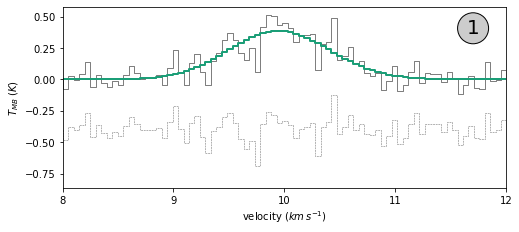

In [18]:
xp = 115
yp = 73

fig, ax = plot_spec_1(x=xp, y=yp, res=True, xlim=(8,12), res_off=0.4, ftcb1=ftcb_1cmp_tk6, lw_md=2, 
                      c_md_t='#1b9e77', res_ls='dashed')

ax.text( 0.94, 0.85, '1', horizontalalignment='right', transform=ax.transAxes, color='k', fontsize=20, 
                  bbox=dict(boxstyle="circle", fc="0.8", alpha=1))

fig.savefig('plots/example_spectra/x{0}y{1}_1cmp.pdf'.format(xp, yp))

#### 2-component fit

tex > trot in the ammonia model.  This is unphysical and suggests that you may need to constrain tex.  See ammonia_model_restricted_tex.


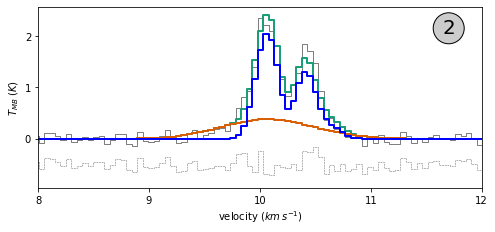

In [19]:
xp = 125
yp = 59

fig, ax = plot_spec_2(x=xp, y=yp, indiv=True,res=True, xlim=(8,12),res_off=0.5, ftcb2=ftcb_2cmp_tk6, 
                      c_md_b='b', c_md_n='#d95f02', c_md_t='#1b9e77', lw_md=2, res_ls='dashed')

ax.text( 0.94, 0.85, '2', horizontalalignment='right', transform=ax.transAxes, color='k', fontsize=20, 
                  bbox=dict(boxstyle="circle", fc="0.8", alpha=1))

fig.savefig('plots/example_spectra/x{0}y{1}_2cmp.pdf'.format(xp, yp))

#### 3-component fit

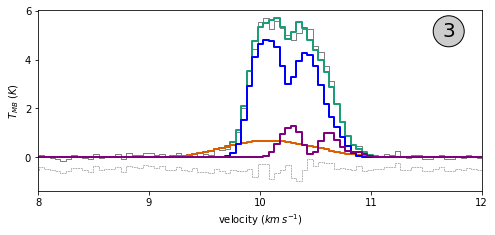

In [20]:
xp = 94
yp = 94

fig, ax = plot_spec_3(x=xp, y=yp, indiv=True, res=True, xlim=(8,12),res_off=0.5, ftcb3=ftcb_3cmp_tk6, 
                      c_md_1='#d95f02', c_md_2='b', c_md_3='purple', c_md_t='#1b9e77', lw_md=2, res_ls='dashed') 

ax.text( 0.94, 0.85, '3', horizontalalignment='right', transform=ax.transAxes, color='k', fontsize=20, 
                  bbox=dict(boxstyle="circle", fc="0.8", alpha=1))

fig.savefig('plots/example_spectra/x{0}y{1}_3cmp.pdf'.format(xp, yp))

## Plot velocities and velocity dispersions of different components

#### obtain data from files

In [18]:
arr1_1 = fits.getdata('sorted_comps/first_sort_vel-sig-tmb_extended.fits')   # extended component
                                     
dark_blue_arr = fits.getdata('sorted_comps/dark_blue_vel-sig-tmb.fits')      # dark blue component
mid_blue_arr = fits.getdata('sorted_comps/mid_blue_vel-sig-tmb.fits')        # mid blue component
mid_red_arr = fits.getdata('sorted_comps/mid_red_vel-sig-tmb.fits')          # mid red component
dark_red_arr = fits.getdata('sorted_comps/dark_red_vel-sig-tmb.fits')        # dark red component

### extended component

##### centroid velocity

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


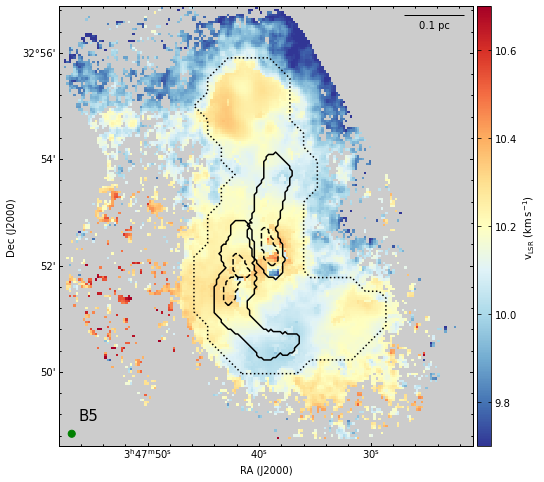

In [19]:
vel_ext = arr1_1[0]*(snr>4)         # only consider pixels with SNR>4, for 'good' single-component fit
vel_ext[vel_ext == 0] = np.nan      # set other pixels as NaNs

# show plot
fig = aplpy_plot(data=vel_ext, hd=hd2d, cmap='RdYlBu_r', zoom=True, fgsz=(6,10), contours=True, 
                 background_grey=True)

# label condensations

# fig.add_label( 0.534, 0.52, 'cond-1', relative=True, color='k',size=10, weight=500, rotation=70, 
#               horizontalalignment='left')
# fig.add_label( 0.38, 0.47, 'cond-2', relative=True, color='k',size=10, weight=500, rotation=60)
# fig.add_label( 0.45, 0.28, 'cond-3', relative=True, color='k',size=10, weight=500, rotation=310)

# show the coherent core boundary
fig.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')

fig.savefig('plots/vel_extended_w-coh-cont.pdf', dpi=1000)

##### velocity dispersion

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


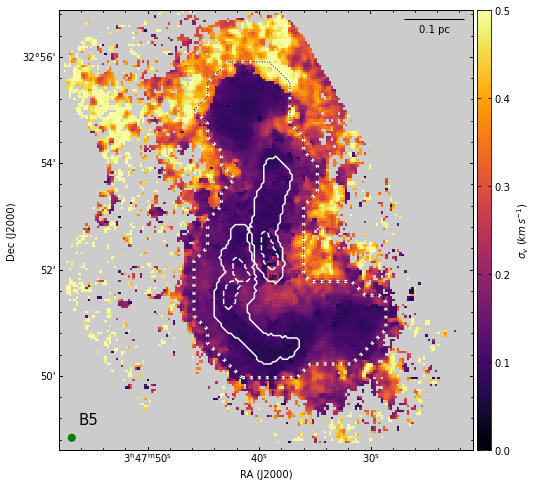

In [20]:
sig_ext = arr1_1[1]*(snr>4)         # only consider pixels with SNR>4, for 'good' single-component fit
sig_ext[sig_ext == 0] = np.nan      # set other pixels as NaNs

# show plot
fig = aplpy_plot(data=sig_ext, hd=hd2d, cmap='inferno', zoom=True, fgsz=(6,10), vmin=0, vmax=0.5, contours=True, 
                 contour_clr='w', background_grey=True, colourbar_text=r'$\sigma_v\ (km\,s^{-1}$)')

# show the coherent core boundary
fig.show_contour(coh_core_bndry_fle, levels=[0.5], colors='w', linestyles='dotted', linewidths=3)
fig.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted', linewidths=1)


fig.savefig('plots/sig_extended_w-coh-cont.pdf', dpi=200)

### Additional components

##### centroid velocity

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to 

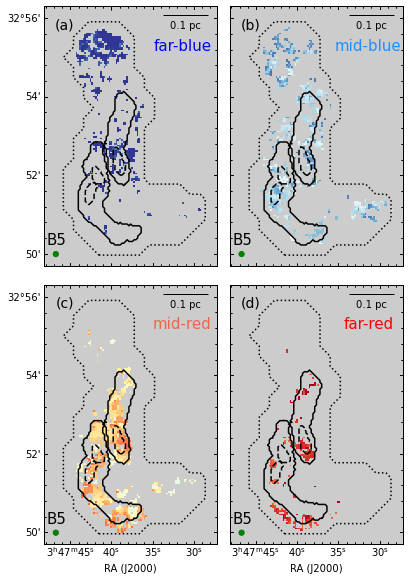

In [21]:
# create actual figure instance
fig = plt.figure(figsize=(6,9))

# subplot with dark blue component
fig1 = aplpy_plot(fig=fig, data=dark_blue_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.12, 0.5, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, contours=True, background_grey=True, y_bm_lbl=0.1)

fig1.tick_labels.hide_x()
fig1.axis_labels.hide()

# subplot with mid blue component
fig2 = aplpy_plot(fig=fig, data=mid_blue_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.55, 0.5, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, contours=True, background_grey=True, y_bm_lbl=0.1)
fig2.tick_labels.hide()
fig2.axis_labels.hide()

# subplot with mid red component
fig3 = aplpy_plot(fig=fig, data=mid_red_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.12, 0.07, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, contours=True, background_grey=True, y_bm_lbl=0.1)
fig3.axis_labels.hide_y()

# subplot with dark red component
fig4 = aplpy_plot(fig=fig, data=dark_red_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.55, 0.07, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, contours=True, background_grey=True, y_bm_lbl=0.1)
fig4.tick_labels.hide_y()
fig4.axis_labels.hide_y()

# zoom on each subplot to clearly show the filaments
fig1.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig2.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig3.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig4.recenter(56.907, 32.8833, width=0.07, height=0.11)

# write name of components shown on each subplot
fig1.add_label( 0.8, 0.85, 'far-blue', relative=True, color='b', size=15, weight=500)
fig2.add_label( 0.8, 0.85, 'mid-blue', relative=True, color='dodgerblue', size=15, weight=500)
fig3.add_label( 0.8, 0.85, 'mid-red', relative=True, color='#ef6548', size=15, weight=500)
fig4.add_label( 0.8, 0.85, 'far-red', relative=True, color='r', size=15, weight=500)

# add labels to the subplots 
fig1.add_label( 0.12, 0.93, '(a)', relative=True, color='k', size=14, weight=500)
fig2.add_label( 0.12, 0.93, '(b)', relative=True, color='k', size=14, weight=500)
fig3.add_label( 0.12, 0.93, '(c)', relative=True, color='k', size=14, weight=500)
fig4.add_label( 0.12, 0.93, '(d)', relative=True, color='k', size=14, weight=500)

# show the coherent core boundary
fig1.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig2.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig3.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig4.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')

plt.tight_layout()
fig.savefig('plots/vel_4-extra-comp_w-coh-cont_new.pdf', dpi=1000)

##### velocity dispersion

In [ ]:
# create actual figure instance
fig = plt.figure(figsize=(6,10))


# subplot with dark blue component
fig1 = aplpy_plot(fig=fig, data=dark_blue_arr[1], hd=hd2d, cmap='inferno', zoom=True, sbplt=[0.12, 0.52, 0.4, 0.425], 
                  colourbar=False, vmin=0, vmax=0.4, contours=True, contour_clr='w', background_grey=True, y_bm_lbl=0.1)

fig1.tick_labels.hide_x()
fig1.axis_labels.hide_x()



# subplot with mid blue component
fig2 = aplpy_plot(fig=fig, data=mid_blue_arr[1], hd=hd2d, cmap='inferno', zoom=True, sbplt=[0.55, 0.52, 0.4, 0.425], 
                  colourbar=False, vmin=0, vmax=0.4, contours=True, contour_clr='w', background_grey=True, y_bm_lbl=0.1)
fig2.tick_labels.hide()
fig2.axis_labels.hide()


# subplot with mid red component
fig3 = aplpy_plot(fig=fig, data=mid_red_arr[1], hd=hd2d, cmap='inferno', zoom=True, sbplt=[0.12, 0.07, 0.4, 0.425], 
                  colourbar=False, vmin=0, vmax=0.4, contours=True, contour_clr='w', background_grey=True, y_bm_lbl=0.1)

# subplot with dark red component
fig4 = aplpy_plot(fig=fig, data=dark_red_arr[1], hd=hd2d, cmap='inferno', zoom=True, sbplt=[0.55, 0.07, 0.4, 0.425], 
                  colourbar=False, vmin=0, vmax=0.4, contours=True, contour_clr='w', background_grey=True, y_bm_lbl=0.1)
fig4.tick_labels.hide_y()
fig4.axis_labels.hide_y()

# zoom on each subplot to clearly show the filaments
fig1.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig2.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig3.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig4.recenter(56.907, 32.8833, width=0.07, height=0.11)

# write name of components shown on each subplot
fig1.add_label( 0.8, 0.5, 'far-blue', relative=True, color='b', size=15, weight=500)
fig2.add_label( 0.8, 0.5, 'mid-blue', relative=True, color='dodgerblue', size=15, weight=500)
fig3.add_label( 0.8, 0.5, 'mid-red', relative=True, color='#ef6548', size=15, weight=500)
fig4.add_label( 0.8, 0.5, 'far-red', relative=True, color='r', size=15, weight=500)

# add labels to the subplots 
fig1.add_label( 0.12, 0.93, '(a)', relative=True, color='k', size=14, weight=500)
fig2.add_label( 0.12, 0.93, '(b)', relative=True, color='k', size=14, weight=500)
fig3.add_label( 0.12, 0.93, '(c)', relative=True, color='k', size=14, weight=500)
fig4.add_label( 0.12, 0.93, '(d)', relative=True, color='k', size=14, weight=500)

# show the coherent core boundary
fig1.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig2.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig3.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')
fig4.show_contour(coh_core_bndry_fle, levels=[0.5], colors='k', linestyles='dotted')

plt.tight_layout()
fig.savefig('plots/sig_4-extra-comp_w-coh-cont.pdf', dpi=1000)

### Bayes K maps

In [6]:
K_arr_12 = fits.getdata('bayesian_fit_files/B5-Ks.fits')
K_arr_34 = fits.getdata('bayesian_fit_files/B5-Ks.fits')

##### set pixels with SNR<=4 to NaNs

In [7]:
K_arr_01_snr5 = K_arr_12[0].copy()
K_arr_01_snr5[K_arr_01_snr5 == 0] = -2
K_arr_01_snr5 = K_arr_01_snr5*(snr>4)
K_arr_01_snr5[K_arr_01_snr5 == 0] = np.nan
K_arr_01_snr5[K_arr_01_snr5 == -2] = 0

In [8]:
K_arr_12_snr5 = K_arr_12[1].copy()
K_arr_12_snr5[K_arr_12_snr5 == 0] = -2
K_arr_12_snr5 = K_arr_12_snr5*(snr>4)
K_arr_12_snr5[K_arr_12_snr5 == 0] = np.nan
K_arr_12_snr5[K_arr_12_snr5 == -2] = 0

In [9]:
K_arr_23_snr5 = K_arr_34[2].copy()
K_arr_23_snr5[K_arr_23_snr5 == 0] = -2
K_arr_23_snr5 = K_arr_23_snr5*(snr>4)
K_arr_23_snr5[K_arr_23_snr5 == 0] = np.nan
K_arr_23_snr5[K_arr_23_snr5 == -2] = 0

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


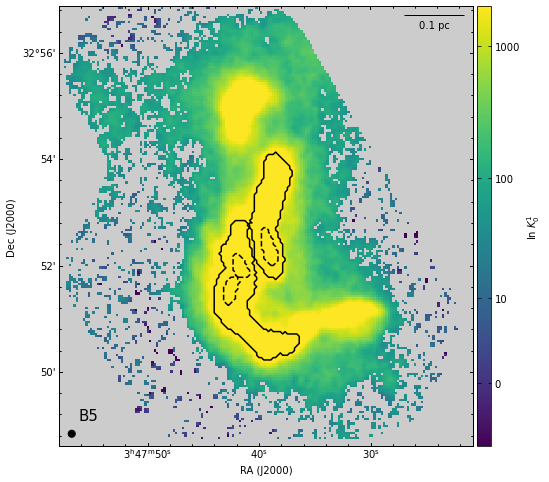

In [10]:
lcmap = 'viridis'

fig = aplpy_plot(data=K_arr_01_snr5, hd=hd2d, cmap=lcmap, zoom=True, fgsz=(6,10), vmin=-2, vmax=2000, vmid=-3,
                 colourbar_text=r'ln $K^1_0$', background_grey=True, beam_colour='k', contours=True, 
                colourscale_stretch='log')

fig.colorbar.set_ticks([0, 10, 100, 1000])

    
fig.savefig('plots/K01_arr_w-contours.pdf', dpi=200)

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


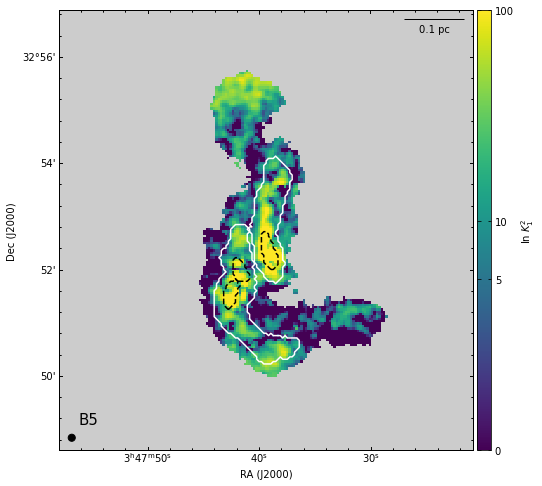

In [11]:
lcmap = 'viridis'


fig = aplpy_plot(data=K_arr_12_snr5, hd=hd2d, cmap=lcmap, zoom=True, fgsz=(6,10), vmin=0, vmax=100, vmid=-1,
                 colourbar_text=r'ln $K^2_1$', background_grey=True, beam_colour='k', contours=False, 
                colourscale_stretch='log')

fig.colorbar.set_ticks([0, 5, 10, 100])

# show contours of filaments and condensations
fig.show_contour(msk_regs['fil1'], colors=['w'], levels=[0])
fig.show_contour(msk_regs['fil2'], colors=['w'], levels=[0])

fig.show_contour(msk_regs['cnd1'], colors=['k'], levels=[0], linestyles='dashed')
fig.show_contour(msk_regs['cnd2'], colors=['k'], levels=[0], linestyles='dashed')
fig.show_contour(msk_regs['cnd3'], colors=['k'], levels=[0], linestyles='dashed')
    
fig.savefig('plots/K12_arr_w-contours.pdf', dpi=200)

'obsfix' made the change 'Set OBSGEO-L to  -107.618000 from OBSGEO-[XYZ].
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


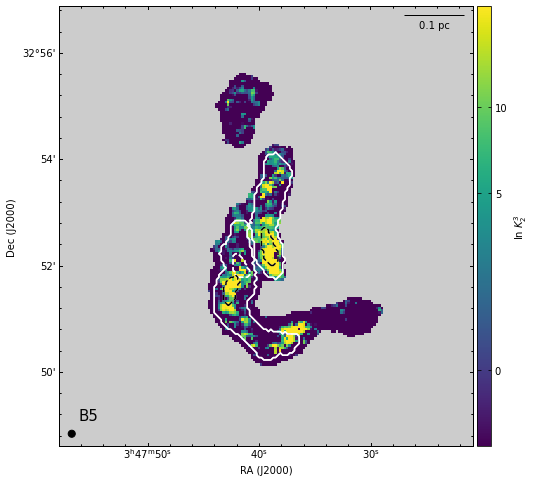

In [12]:
lcmap = 'viridis'


fig = aplpy_plot(data=K_arr_23_snr5, hd=hd2d, cmap=lcmap, zoom=True, fgsz=(6,10), vmin=-1, vmax=20, vmid=-3,
                 colourbar_text=r'ln $K^3_2$', background_grey=True, beam_colour='k', contours=True, 
                colourscale_stretch='log', contour_clr='w')

fig.colorbar.set_ticks([0, 5, 10])

# show contours of filaments and condensations
fig.show_contour(msk_regs['fil1'], colors=['w'], levels=[0])
fig.show_contour(msk_regs['fil2'], colors=['w'], levels=[0])

fig.show_contour(msk_regs['cnd1'], colors=['k'], levels=[0], linestyles='dashed')
fig.show_contour(msk_regs['cnd2'], colors=['w'], levels=[0], linestyles='dashed')
fig.show_contour(msk_regs['cnd3'], colors=['k'], levels=[0], linestyles='dashed')
    
fig.savefig('plots/K23_arr_w-contours.pdf', dpi=200)